In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import afterglowpy as grb

In [2]:
def loadDataFromFile(filename):
    """
    Load GRB afterglow data from a .txt file.
    
    Arguments
    
        filename: the name (and path) to the data file.
        
    Returns
        
        t: array
            observed times in seconds
        nu: array
            observed frequency in Hz
        Fnu: array
            observed flux in mJy
        Ferr: array
            uncertainty in observed flux in mJy
    """
    
    
    t_all, nu_all, Fnu_all, Ferr_all, ul_all = np.loadtxt(filename, usecols=[0,1,2,3,4], unpack=True)
    
    detections = (ul_all == 0.0)
    t_det = t_all[detections]
    nu_det = nu_all[detections]
    Fnu_det = Fnu_all[detections]
    Ferr_det = Ferr_all[detections]
    
    return t_det, nu_det, Fnu_det, Ferr_det
    

In [18]:
# Load the data!

t_data, nu_data, Fnu_data, Ferr_data = loadDataFromFile("../data/160509A_data.txt")

In [19]:
print(nu_data)

[1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 5.00000000e+09 7.40000000e+09 8.50000000e+09 1.10000000e+10
 5.00000000e+09 7.40000000e+09 8.50000000e+09 1.10000000e+10
 1.35000000e+10 1.60000000e+10 1.92000000e+10 2.45000000e+10
 3.00000000e+10 3.70000000e+10 5.00000000e+09 7.40000000e+09
 1.92000000e+10 2.45000000e+10 5.00000000e+09 7.40000000e+09
 8.50000000e+09 1.10000000e+10 1.35000000e+10 1.60000000e+10
 1.92000000e+10 2.45000000e+10 3.00000000e+10 3.70000000e+10
 1.64400000e+09 2.67900000e+09 3.52300000e+09 5.00000000e+09
 7.40000000e+09 8.50000000e+09 1.10000000e+10 1.35000000e+10
 1.60000000e+10 1.920000

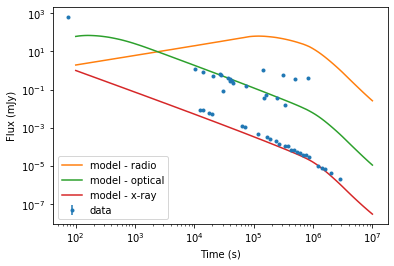

Text(0, 0.5, 'flux $F_\\nu$ (mJy)')

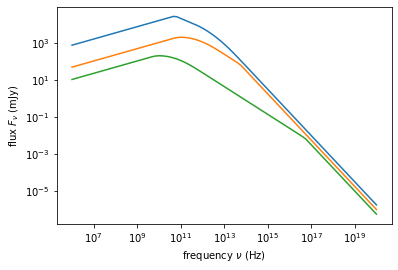

In [5]:
# Times and Frequencies for the model
t = np.geomspace(1.0e2, 1.0e7, 100)

nuR = np.empty(t.shape)
nuR[:] = 1.5e10

nuO = np.empty(t.shape)
nuO[:] = 4.67706708e+14

nuX = np.empty(t.shape)
nuX[:] = 1.2e18

# Parameters for the model
Z = {'jetType': grb.jet.TopHat,  # type of jet structure
     'specType': 0,              # type of spectrum
     'thetaObs': 0.0,   # observer angle (radians)
     'E0': 1.0e55,      # isotropic energy (erg)
     'thetaCore': 0.25, # jet opening angle (radians)
     'n0': 150.0,         # ambient ISM density (cm^{-3})
     'p': 2.5,          # electron energy slope (no units)
     'epsilon_e': 0.1,  # fraction of energy in accelerated electrons (no units)
     'epsilon_B': 0.0000001, # fraction of energy in magnetic field (no units)
     'ksiN': 1.0,       # fraction of electrons that get accelerated (no units)
     'dL': 1.21e28,     # luminosity distance (cm)
     'z': 0.654         # redshift (no units)
    } 

# Calculate the model!
FnuR = grb.fluxDensity(t, nuR, **Z)  # the model, theoretical prediction
FnuO = grb.fluxDensity(t, nuO, **Z)  # the model, theoretical prediction
FnuX = grb.fluxDensity(t, nuX, **Z)  # the model, theoretical prediction

# Plot the data
plt.errorbar(t_data, Fnu_data, Ferr_data, ls='', marker='.', label='data')

# Plot the model
plt.plot(t, FnuR, label='model - radio')
plt.plot(t, FnuO, label='model - optical')
plt.plot(t, FnuX, label='model - x-ray')

# Scale the Axes
plt.xscale('log')
plt.yscale('log')

# Add a legend
plt.legend()

# Add some labels
plt.xlabel('Time (s)')
plt.ylabel('Flux (mJy)')
plt.show()


nu_spec = np.geomspace(1.0e6, 1.0e20, 100)
t_spec = np.empty(nu_spec.shape)
t_spec[:] = 3.0e5

Z['epsilon_B'] = 0.01
Fnu_spec1 = grb.fluxDensity(t_spec, nu_spec, **Z)

Z['epsilon_B'] = 0.0001
Fnu_spec2 = grb.fluxDensity(t_spec, nu_spec, **Z)

Z['epsilon_B'] = 0.000001
Fnu_spec3 = grb.fluxDensity(t_spec, nu_spec, **Z)


plt.loglog(nu_spec, Fnu_spec1)
plt.loglog(nu_spec, Fnu_spec2)
plt.loglog(nu_spec, Fnu_spec3)
plt.xlabel(r'frequency $\nu$ (Hz)')
plt.ylabel(r'flux $F_\nu$ (mJy)')

In [30]:
def fit_function(xdata, logE0, thetaCore, logn0, p, logepse, logepsB):
    """
    Assumes xdata = {'t_data': t_data, 'nu_data': nu_data, 'Z': Z}
    """
    t_data = xdata['t_data']
    nu_data = xdata['nu_data']
    Z = xdata['Z']
    
    Z['E0'] = 10.0**logE0
    Z['thetaCore'] = thetaCore
    Z['n0'] = 10.0**logn0
    Z['p'] = p
    Z['epsilon_e'] = 10.0**logepse
    Z['epsilon_B'] = 10.0**logepsB
    
    # print(logE0, thetaCore, logn0, p, logepse, logepsB)
    
    Fnu = grb.fluxDensity(t_data, nu_data, **Z)
    
    return Fnu


def chi2_function(Fnu_model, Fnu_data, Ferr_data):
    
    residual = (Fnu_model - Fnu_data) / Ferr_data
    
    return np.sum( residual**2 )


def filter_data(t, nu, Fnu, Ferr):
    
    bad = (t > 50) & (t < 100)  
    # bad = (nu > 4.7e14) & (nu < 4.8e14)
  
    good = ~bad  # good = not bad
    
    # t    = [3e4, 5e4,  2e6,  100]
    # nu   = [1e6, 1e6,  1e17, 1e14]
    # Fnu  = [0.1, 0.05, 1e-7, 1e-4]
    # Ferr = [0.1, 0.05, 1e-7, 1e-4]
    #
    # Ferr / Fnu
    #
    
    t_filtered = t[good]
    nu_filtered = nu[good]
    Fnu_filtered = Fnu[good]
    Ferr_filtered = Ferr[good]
    
    return t_filtered, nu_filtered, Fnu_filtered, Ferr_filtered
    

In [25]:
# Parameters for the model
Zguess = {'jetType': grb.jet.TopHat,  # type of jet structure
          'specType': 0,              # type of spectrum
          'thetaObs': 0.0,   # observer angle (radians)
          'E0': 1.0e54,      # isotropic energy (erg)
          'thetaCore': 0.1, # jet opening angle (radians)
          'n0': 1.0,         # ambient ISM density (cm^{-3})
          'p': 2.5,          # electron energy slope (no units)
          'epsilon_e': 0.1,  # fraction of energy in accelerated electrons (no units)
          'epsilon_B': 0.0001, # fraction of energy in magnetic field (no units)
          'ksiN': 1.0,       # fraction of electrons that get accelerated (no units)
          'dL': 1.21e28,     # luminosity distance (cm)
          'z': 0.654         # redshift (no units)
         } 

# Load the data!
t_all, nu_all, Fnu_all, Ferr_all = loadDataFromFile("../data/180720B_data.txt")
t_data, nu_data, Fnu_data, Ferr_data = filter_data(t_all, nu_all, Fnu_all, Ferr_all)

#Package fixed data
xdata = {'t_data': t_data,
         'nu_data': nu_data,
         'Z': Zguess}

#Compute model with guess values
Fnu_model = fit_function(xdata, 53, 0.1, 0.0, 2.5, -1, -4)

#compute chi2 of guess
print(chi2_function(Fnu_model, Fnu_data, Ferr_data))

53 0.1 0.0 2.5 -1 -4
88974.32878061589


[53.85992782  0.06784763 -2.94790799  2.32496159 -0.61659325 -2.9744396 ]
[[ 5.10467125e-02 -5.73306719e-03 -2.39369113e-01  1.71280378e-03
  -5.02384998e-02  1.37600190e-01]
 [-5.73306719e-03  6.48551076e-04  2.70978077e-02 -1.84616007e-04
   5.66199304e-03 -1.56228655e-02]
 [-2.39369113e-01  2.70978077e-02  1.13310097e+00 -7.72638349e-03
   2.36567646e-01 -6.53548007e-01]
 [ 1.71280378e-03 -1.84616007e-04 -7.72638349e-03  1.03804061e-04
  -1.61962009e-03  4.27090849e-03]
 [-5.02384998e-02  5.66199304e-03  2.36567646e-01 -1.61962009e-03
   4.96010842e-02 -1.36346350e-01]
 [ 1.37600190e-01 -1.56228655e-02 -6.53548007e-01  4.27090849e-03
  -1.36346350e-01  3.77782396e-01]]
8152.429769326453


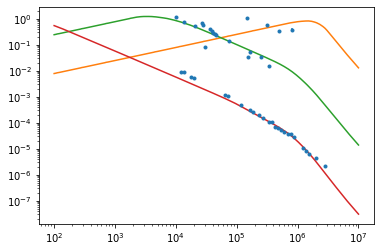

In [53]:
# Try a fit!
#.        E0.    thetaCore density  p 
guess = [53,   0.25,      0.0,     2.5, -1.0, -4.0]

# n0 = 150
# log10(100) = 2
# log10(1000) = 3
# log10(150) ~ 2.1

# Set bounds
lower_bounds = np.array([48, 0.0,     -5, 2.0, -5.0, -5.0])
upper_bounds = np.array([56, np.pi/2,  5, 3.0, -0.5, -0.5])
bounds = (lower_bounds, upper_bounds)

popt, pcov = scipy.optimize.curve_fit(fit_function, xdata, Fnu_data, sigma=Ferr_data,
                                      p0=guess, bounds=bounds, absolute_sigma=True)

print(popt)
print(pcov)

#Compute model with guess values
Fnu_model = fit_function(xdata, *popt)

#Compute chi2 of guess
print(chi2_function(Fnu_model, Fnu_data, Ferr_data))

t = np.geomspace(1.0e2, 1.0e7, 300)

Zguess['counterjet'] = True

nuR = np.empty(t.shape)
nuR[:] = 1.55000000e+10

nuO = np.empty(t.shape)
nuO[:] = 4.67706708e+14

nuX = np.empty(t.shape)
nuX[:] = 1.20899462e+18

xdataR = {'t_data': t,
         'nu_data': nuR,
         'Z': Zguess}
xdataO = {'t_data': t,
         'nu_data': nuO,
         'Z': Zguess}
xdataX = {'t_data': t,
          'nu_data': nuX,
          'Z': Zguess}

# Calculate the model!
FnuR = fit_function(xdataR, *popt)
FnuO = fit_function(xdataO, *popt)
FnuX = fit_function(xdataX, *popt)

# Plot the data
plt.errorbar(t_data, Fnu_data, Ferr_data, ls='', marker='.', label='data')

# Plot the model
plt.plot(t, FnuR, label='model - radio')
plt.plot(t, FnuO, label='model - optical')
plt.plot(t, FnuX, label='model - x-ray')

plt.xscale('log')
plt.yscale('log')



plt.show()

In [54]:
def computeResults(popt, pcov):

    logE0_best = popt[0]
    thetaC_best = popt[1]
    logn0_best = popt[2]
    p_best = popt[3]
    logepse_best = popt[4]
    logepsB_best = popt[5]

    logE0_err = np.sqrt(pcov[0, 0])
    thetaC_err = np.sqrt(pcov[1, 1])
    logn0_err = np.sqrt(pcov[2, 2])
    p_err = np.sqrt(pcov[3, 3])
    logepse_err = np.sqrt(pcov[4, 4])
    logepsB_err = np.sqrt(pcov[5, 5])

    print("log_E0:", logE0_best, "+/-", logE0_err, "erg")
    print("theta_core:", thetaC_best, "+/-", thetaC_err, "rad")
    print("log_n0:", logn0_best, "+/-", logn0_err, "cm**-3")
    print("p:", p_best, "+/-", p_err)
    print("log_epsilon_e:", logepse_best, "+/-", logepse_err)
    print("log_epsilon_B:", logepsB_best, "+/-", logepsB_err)

    E0_best = 10.0 ** logE0_best
    E0_err = E0_best * np.log(10.0) * logE0_err

    Etot_best = E0_best * (1-np.cos(thetaC_best))
    Etot_err = Etot_best * (E0_err / E0_best  +  np.sin(thetaC_best) * thetaC_err / (1-np.cos(thetaC_best)))

    # Etot_best_approx = 0.5 * E0_best * thetaC_best**2
    # Etot_approx_err = Etot_best_approx * (E0_err / E0_best + 2*thetaC_err / thetaC_best)

    print("E0:", E0_best, "+/-", E0_err, "erg")
    print("E_total:", Etot_best, "+/-", Etot_err, "erg")
    # print("E_total_approx:", Etot_best_approx, "+/-", Etot_approx_err, "erg")
    
    # logEtot_best = np.log10(Etot_best)
    # logEtot_err = Etot_err / (Etot_best * np.log(10.0))
    
    # print("log_E_total:", logEtot_best, "+/-", logEtot_err)
    
    
computeResults(popt, pcov)


log_E0: 53.85992781629042 +/- 0.22593519542138885 erg
theta_core: 0.06784762704851074 +/- 0.02546666598339066 rad
log_n0: -2.9479079932674908 +/- 1.0644721569738322 cm**-3
p: 2.3249615870193985 +/- 0.010188427784128349
log_epsilon_e: -0.6165932508631988 +/- 0.22271300862256313
log_epsilon_B: -2.9744396037678578 +/- 0.6146400537415689
E0: 7.243155622075856e+53 +/- 3.7681431589218323e+53 erg
E_total: 1.6664816699357805e+51 +/- 2.1175128668195603e+51 erg


In [32]:
print(nu_data)

[1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.55000000e+10 1.55000000e+10 1.55000000e+10
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 1.40000000e+09]
